In [231]:
import torch
from torch import nn
import math
import torch.nn.functional as F

In [232]:
batch_size = 3
h = 1
d_model = 5
d_k = d_model // h
seq_length = 4

https://habr.com/en/companies/ods/articles/708672/

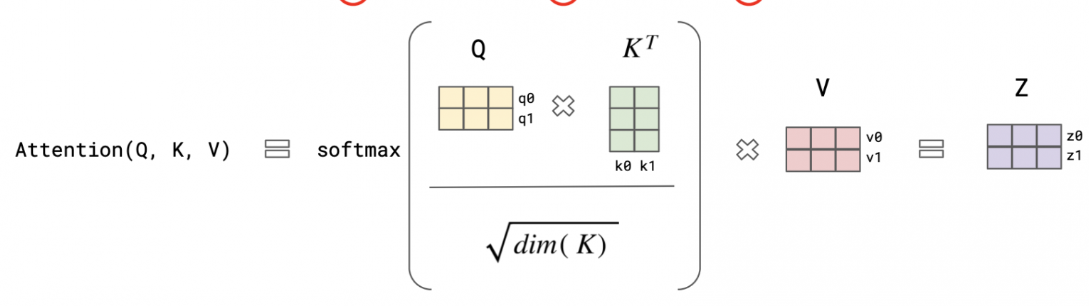

In [257]:
# paper implementation
class AttentionHead(nn.Module):
    """
    One head of the self-attention layer
    """

    def __init__(self, d_k, d_model, seq_length):
        super().__init__()
        self.key = nn.Linear(d_model, d_k, bias=False)
        self.query = nn.Linear(d_model, d_k, bias=False)
        self.value = nn.Linear(d_model, d_k, bias=False)
        # tril is a lower triangular matrix. it is not a parameter
        # of the model, so we assign it to the module using register_buffer
        self.register_buffer("tril", torch.tril(torch.ones(seq_length, seq_length)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute attention scores
        # (B, T, C) @ (B, C, T) -> (B, T, T)
        # we need to transpose k to match q
        wei = q @ k.transpose(-2, -1) * C**-0.5
        # Tril matrix (lower triagular matrix) is used to mask 
        # future positions (setting them to -inf) so that the
        # decoder "learns" to predict next words
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B,T,T)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        # weighted aggregation of the values
        v = self.value(x)
        out = wei @ v  # (B,T,T) @ (B,T,C) ---> (B,T,C)
        return out

In [256]:
# my own implementation
class AttentionHead2(nn.Module):
    """
    One head of the self-attention layer
    """

    def __init__(self, d_k, d_model, seq_length):
        super().__init__()

        self.wq = nn.Linear(in_features=d_model,out_features=d_k,bias=False)
        self.wk = nn.Linear(in_features=d_model,out_features=d_k,bias=False)
        self.wv = nn.Linear(in_features=d_model,out_features=d_k,bias=False)
        
    def forward(self, x):
        # B (batch_size), T (seq_length), C (d_model)
        B, T, C = x.shape

        # (batch_size, seq_length, d_model) -> (batch_size, seq_length, d_k)
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        # print(k.shape)

        # (batch_size, seq_length, d_k) * (batch_size, d_k, seq_length) 
        # -> (batch_size, seq_length, seq_length)
        qkt = q @ k.transpose(-2,-1) / math.sqrt(d_k)
        
        # apply mask (seq_length*seq_length) now
        mask = torch.tril((torch.ones(seq_length,seq_length)==1))==False
        qkt = qkt.masked_fill(mask, -torch.inf)
        
        sm = F.softmax(qkt, dim=-1)

        # (batch_size, seq_length, seq_length) * (batch_size, seq_length, d_model)
        # -> (batch_size, seq_length, d_model)
        att  = sm @ v
        
        return att

    def use_weight_from(self, model):
        lp = list(model.parameters())
        with torch.no_grad():
            assert(self.wq.weight.shape[0]-lp[0].shape[0] == 0), 'incompatible weights'
            assert(self.wq.weight.shape[1]-lp[0].shape[1] == 0), 'incompatible weights'
                        
            self.wk.weight = lp[0]
            self.wq.weight = lp[1]
            self.wv.weight = lp[2]

In [243]:
m1 = AttentionHead(d_k, d_model, seq_length)

In [244]:
m2 = AttentionHead2(d_k, d_model, seq_length)

In [250]:
m2.use_weight_from(m1)

In [251]:
x = torch.rand(batch_size, seq_length, d_model)

In [252]:
y1 = m1(x)

In [253]:
y2 = m2(x)

In [254]:
y1-y2

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)

In [255]:
y1

tensor([[[ 0.1709, -0.2497,  0.1784, -0.0030,  0.5388],
         [ 0.2485, -0.4519,  0.2261, -0.0690,  0.5882],
         [ 0.2811, -0.5672,  0.2900, -0.1190,  0.8113],
         [ 0.2530, -0.4829,  0.2289, -0.1395,  0.8178]],

        [[ 0.2639, -0.2526,  0.1796, -0.0249,  1.0227],
         [ 0.2044, -0.3490,  0.2637, -0.1526,  0.9976],
         [ 0.1301, -0.3659,  0.1855, -0.2255,  0.9770],
         [ 0.2205, -0.5224,  0.2300, -0.2010,  0.9903]],

        [[ 0.4109, -0.5508,  0.2150, -0.2310,  1.1791],
         [ 0.2630, -0.6385,  0.1197, -0.2680,  1.0531],
         [ 0.1532, -0.4014,  0.1234, -0.2232,  0.8915],
         [ 0.1990, -0.4997,  0.1429, -0.1939,  0.9325]]],
       grad_fn=<UnsafeViewBackward0>)